In [2]:
# Set Up
import os
import torch
from torch import nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision

import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /gdrive
/gdrive


In [3]:
# Data Loader
class DataLoader():
  def __init__(self, dir="MyDrive/data", width=300, height=432):
    self.width = width
    self.height = height
    self.root = dir

  def load(self, dataset="/test", batchSize=10, shuffle=True, workers=2):
    transform = transforms.Compose([transforms.Resize((124, 124)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    dataset = datasets.ImageFolder(root=self.root + dataset, transform=transform)
    dataset = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=shuffle, num_workers=workers)
    return dataset


In [4]:
# Multilayer Perceptron
class MLP(nn.Module):
  def __init__(self, inputSize=124*124*3, outputSize=8, lr=0.01):
    super().__init__()

    self.net = nn.Sequential(
      nn.Flatten(),
      nn.Linear(inputSize, 1024),
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, outputSize),
      nn.ReLU(),
    )

    self.lr = lr

  def forward(self, X):
    return self.net(X)

  def loss(self, y_hat, y):
    # print(y, y_hat)
    fn = nn.CrossEntropyLoss()
    return fn(y_hat, y)

  def configureOptimiser(self):
    return torch.optim.Adam(self.parameters(), self.lr)

In [5]:
# Trainer Class
class Trainer():
  def __init__(self, nEpochs=3):
    self.maxEpochs = nEpochs

  def expLR(self, lr):
    return lr * 0.95

  # The fitting step
  def fit(self, model, data):

    self.data = data

    # configure the optimizer
    self.optimiser = model.configureOptimiser()
    self.model = model

    for epoch in range(self.maxEpochs):
      print("Epoch: ", epoch + 1)
      self.fitEpoch()
      self.model.lr = self.expLR(self.model.lr)

    print("Training process has finished")

  def fitEpoch(self):
    currentLoss = 0.0

    for i, data in enumerate(self.data):
      # Get input aand its corresponding groundtruth output
      inputs, target = data
      inputs, target = inputs.to(device), target.to(device)

      self.optimiser.zero_grad()

      # get output from the model, given the inputs
      outputs = self.model(inputs)

      # get loss for the predicted output
      loss = self.model.loss(outputs, target)

      # get gradients w.r.t the parameters of the model
      loss.backward()

      # update the parameters (perform optimization)
      self.optimiser.step()

      currentLoss += loss.item()
      if i % 10 == 9:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, currentLoss / 10))
          currentLoss = 0.0

  def evaluate(self, model, data):
    allCorrect = 0
    count = 0
    for images, labels in data:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      estLabel = torch.max(outputs, 1).indices
      correct = sum(estLabel == labels)
      allCorrect += correct
      count += len(outputs)
    print("Correct: ", allCorrect, "Total: ", count)

In [7]:
# Train Model
trainSet = DataLoader().load(dataset="/train", batchSize=32, shuffle=True, workers=2)
model = MLP(lr=1e-05).to(device)
trainer = Trainer(nEpochs=25)
trainer.fit(model, trainSet)
trainer.evaluate(model=model, data=trainSet)

Epoch:  1
Loss after mini-batch    10: 1.951
Loss after mini-batch    20: 1.757
Loss after mini-batch    30: 1.631
Loss after mini-batch    40: 1.585
Loss after mini-batch    50: 1.480
Loss after mini-batch    60: 1.410
Loss after mini-batch    70: 1.510
Loss after mini-batch    80: 1.375
Loss after mini-batch    90: 1.381
Loss after mini-batch   100: 1.346
Epoch:  2
Loss after mini-batch    10: 1.258
Loss after mini-batch    20: 1.346
Loss after mini-batch    30: 1.357
Loss after mini-batch    40: 1.293
Loss after mini-batch    50: 1.328
Loss after mini-batch    60: 1.277
Loss after mini-batch    70: 1.274
Loss after mini-batch    80: 1.274
Loss after mini-batch    90: 1.295
Loss after mini-batch   100: 1.297
Epoch:  3
Loss after mini-batch    10: 1.147
Loss after mini-batch    20: 1.207
Loss after mini-batch    30: 1.166
Loss after mini-batch    40: 1.153
Loss after mini-batch    50: 1.164
Loss after mini-batch    60: 1.122
Loss after mini-batch    70: 1.149
Loss after mini-batch    

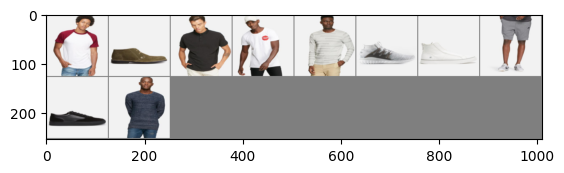

GroundTruth:  tees  shoes tees  tees  knitwear shoes shoes shorts shoes knitwear
Estimated Labels:  accessories shoes accessories accessories shirts shoes shoes shorts shoes knitwear
Correct:  tensor(228) Total:  382


In [8]:
# Evaluate Model
def imgShow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

validloader = DataLoader().load(dataset="/valid", batchSize=10, shuffle=True, workers=2)
classes = validloader.dataset.classes

dataiter = iter(validloader)
images, labels = next(dataiter)

images, labels = images.to(device), labels.to(device)

imgShow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(images.shape[0])))

output = model(images)
estimatedLabels = torch.max(output, 1).indices

print('Estimated Labels: ', ' '.join(f'{classes[estimatedLabels[j]]:5s}' for j in range(images.shape[0])))

trainer.evaluate(model=model, data=validloader)

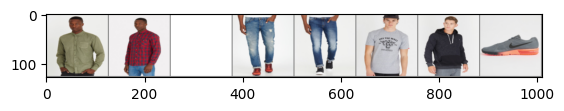

Estimated Labels:  jackets accessories shoes jeans jeans shirts knitwear accessories


In [9]:
testloader = DataLoader().load(dataset="/test", batchSize=10, shuffle=False, workers=2)
dataiter = iter(testloader)
images, labels = next(dataiter)

images = images.to(device)

imgShow(torchvision.utils.make_grid(images))
output = model(images).to(device)
estimatedLabels = torch.max(output, 1).indices

print('Estimated Labels: ', ' '.join(f'{classes[estimatedLabels[j]]:5s}' for j in range(images.shape[0])))